# Introduction

Welcome to the **Few Shot Object Detection for TensorFlow Lite** Colab. Here, we demonstrate fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of a *novel* class. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.

**NOTE:** This Colab is meant for the few-shot detection use-case. To train a model on a large dataset, please follow the [TF2 training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md#training) documentation and then [convert](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md) the model to TensorFlow Lite.

# Set Up

## Imports

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2802, done.
remote: Counting objects: 100% (2802/2802), done.
remote: Compressing objects: 100% (2336/2336), done.
remote: Total 2802 (delta 716), reused 1283 (delta 430), pack-reused 0
Receiving objects: 100% (2802/2802), 32.79 MiB | 29.68 MiB/s, done.
Resolving deltas: 100% (716/716), done.


In [2]:
# Install the Object Detection API
%%bash
# comment the two lines below for TPU training
pip install apache-beam[gcp]
pip install google-cloud-storage

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-cp37-none-any.whl size=43516 sha256=74023f46394976b6c915582ffbbfdfcab178052953dace9ee66ea84c4ce7bac0
  Stored in directory: /root/.cache/pip/wheels/5a/d3/be/86620c9dd3fca68986c33b9c616510289fc0abb81ec9aa70bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=493b9b2b55c81ef35d5d5a5739ae99be29866dd5c52d81a0878453fdad947c74
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=d7f0e1e614ffa8e132efe33afe2af9cd1936acc03a51e16d1f9d7ce127f9bdcc
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for google-apitools: filename=google_apitools-0.5.31-cp37-none-any.whl size=131043 sha256=3d1f93ac08ff4cbfb583b0a0277defaa27b223814b29588b571dd342bc68b9c4
  Stored in directory: /root/.cache/pip/w

ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.26.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: google-cloud-spanner 1.19.1 has requirement google-cloud-core<2.0dev,>=1.4.1, but you'll have google-cloud-core 1.0.3 which is incompatible.
ERROR: google-cloud-bigtable 1.7.0 has requirement google-cloud-core<2.0dev,>=1.4.1, but you'll have google-cloud-core 1.0.3 which is incompatible.


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from shutil import copyfile
from shutil import rmtree
import zipfile

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.core import preprocessor

%matplotlib inline

##Utilities

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

def convert_ppm_images(ppm_directory, 
                       jpg_directory):
  """Function to convert a directory with ppm images to jpg 

  Args:
    ppm_directory: path to the directory with the ppm image to convert 
    jpg_directory: output directory where the converted images shall be stored
  """

  if not os.path.exists(jpg_directory):
    os.makedirs(jpg_directory)

  for f in os.listdir(ppm_directory): 
    if f.endswith(".ppm"):
      image = Image.open(os.path.join(ppm_directory, f))
      image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(f))[0])
      image.save(os.path.join(jpg_directory, image_filename))


## Dataset conversion

Our dataset comes from **GTSDB** - The German Traffic Sign Detection Benchmark ([website](https://benchmark.ini.rub.de/gtsdb_dataset.html)). 

In [5]:
#Fetch images from GTSDB website
if not os.path.isfile("FullIJCNN2013.zip"):
  !curl -LOC - https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip


TMP_DATA_DIR = "dataset/tmp/"
TRAINING_DATA_DIR = "dataset/train/"

to_unpack = [
    ("FullIJCNN2013.zip", TMP_DATA_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1584M  100 1584M    0     0  17.9M      0  0:01:28  0:01:28 --:--:-- 18.4M
Unzipping FullIJCNN2013.zip to dataset/tmp/...


In [6]:
# copy images to train and ground truth to dataset directory 
convert_ppm_images(TMP_DATA_DIR + "FullIJCNN2013/", TRAINING_DATA_DIR)
copyfile(TMP_DATA_DIR + "FullIJCNN2013/gt.txt", TRAINING_DATA_DIR + "/gt.txt")

'dataset/train//gt.txt'

In [7]:
# remove temporary files 
rmtree(TMP_DATA_DIR)

# Transfer Learning


## Data Preparation

First, we populate the groundtruth with pre-annotated bounding boxes.

We then add the class annotations. We also convert everything to the format that the training loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

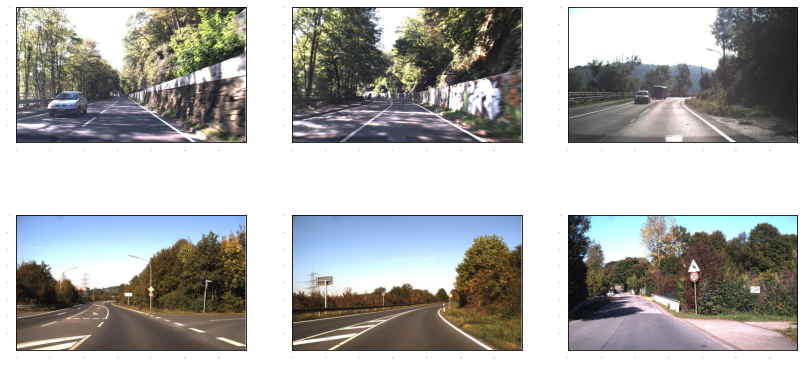

In [8]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just the speedlimit classes

category_index = {1: {'id': 1, 'name': 'speed_limit_20'},
                  2: {'id': 2, 'name': 'speed_limit_30'},
                  3: {'id': 3, 'name': 'speed_limit_50'},
                  4: {'id': 4, 'name': 'speed_limit_60'},
                  5: {'id': 5, 'name': 'speed_limit_70'},
                  6: {'id': 6, 'name': 'speed_limit_80'},
                  7: {'id': 7, 'name': 'restriction_ends'},
                  8: {'id': 8, 'name': 'speed_limit_100'},
                  9: {'id': 9, 'name': 'speed_limit_120'}}

gt_path = os.path.join(TRAINING_DATA_DIR, "gt.txt")

gt_boxes = []
train_images_np = []
class_index = []

#TODO close file directly and copy content into local car
# change for loop to generator yield 
# only append images with speed limit signs 
with open(gt_path, 'r') as gt:
    for idx, line in enumerate(gt):
      image_name = line.split(";")[0].replace('.ppm', '.jpg')
      image_path = os.path.join(TRAINING_DATA_DIR, image_name)
      xmin = float(line.split(";")[1]) / 1360.0
      ymin = float(line.split(";")[2]) / 800.0 
      xmax = float(line.split(";")[3]) / 1360.0
      ymax = float(line.split(";")[4]) / 800.0
      # add offset of 1 to index. Index 0 is a background image without signs 
      class_idx = int(line.rsplit(";", 1)[1]) + 1

      # only add the image to the list, if it show an image of the relevant classes
      if class_idx in category_index:
        train_images_np.append(load_image_into_numpy_array(image_path))
        gt_boxes.append(np.array([[ymin, xmin, ymax, xmax]], dtype=np.float32))
        class_index.append(class_idx)
      

NUM_OF_EVAL_IMAGES = 20
test_gt_boxes= gt_boxes[-NUM_OF_EVAL_IMAGES:]
test_images_np = train_images_np[-NUM_OF_EVAL_IMAGES:]
test_class_index = class_index[-NUM_OF_EVAL_IMAGES:]

gt_boxes = gt_boxes[:-NUM_OF_EVAL_IMAGES]
train_images_np = train_images_np[:-NUM_OF_EVAL_IMAGES]
class_index = class_index[:-NUM_OF_EVAL_IMAGES]


# display some example images of the dataset
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx in range(0, 6):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_images_np[idx])
plt.show()

In [9]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, class_idx) in zip(
    train_images_np, gt_boxes, class_index):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(
      shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset + class_idx)
  gt_classes_one_hot_tensors.append(
      tf.one_hot(zero_indexed_groundtruth_classes, len(category_index)))

print('Done prepping data.')

Done prepping data.


Let's just visualize some signs as a sanity check


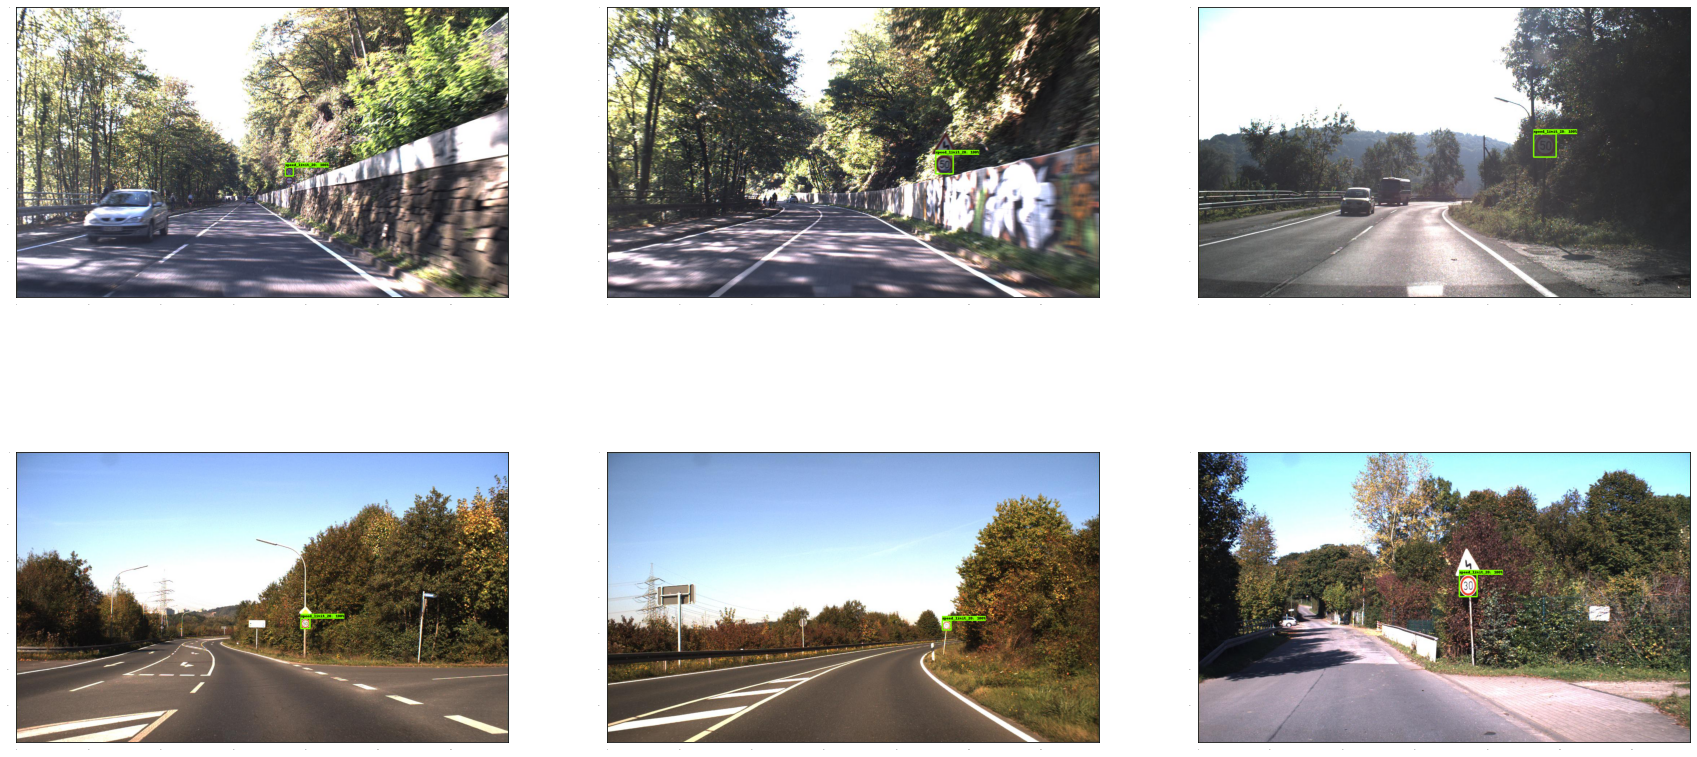

In [10]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Load mobile-friendly model

In this cell we build a mobile-friendly single-stage detection architecture (SSD MobileNet V2 FPN-Lite) and restore all but the classification layer at the top (which will be randomly initialized).

**NOTE**: TensorFlow Lite only supports SSD models for now.

For simplicity, we have hardcoded a number of things in this colab for the specific SSD architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations (`pipeline.config` in the zip downloaded from the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.)).




In [11]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-07-18 08:19:46--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M   115MB/s    in 0.2s    

2021-07-18 08:19:46 (115 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [12]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = len(category_index)
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


## Eager training loop (Fine-tuning)

Some of the parameters in this block have been set empirically: for example, `learning_rate`, `num_batches` & `momentum` for SGD. These are just a starting point, you will have to tune these for your data & model architecture to get the best results.





In [ ]:
#tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 50
learning_rate = 0.1
num_batches = 1000

# image augmentation options, which will be used during training 
preprocess_options = [
                      (preprocessor.random_rgb_to_gray, {}),
                      (preprocessor.random_adjust_brightness, {})]

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = []
  gt_classes_list = []
  image_tensors = []

  for key in example_keys:
    tensor_dict = {"image": train_image_tensors[key], 
                   "groundtruth_boxes": gt_box_tensors[key],
                   "gt_classes_one_hot_tensors": gt_classes_one_hot_tensors[key]}
    gt_boxes_list.append(gt_box_tensors[key])
    gt_classes_list.append(gt_classes_one_hot_tensors[key])

    augmentation_image = preprocessor.preprocess(tensor_dict, preprocess_options)
    image_tensors.append(augmentation_image.get("image"))


  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
batch 0 of 1000, loss=1.2464755
batch 100 of 1000, loss=0.6336404
batch 200 of 1000, loss=0.3892929
batch 300 of 1000, loss=0.4469244
batch 400 of 1000, loss=0.43139964
batch 500 of 1000, loss=0.3754694
batch 600 of 1000, loss=0.40106207
batch 700 of 1000, loss=0.39279845


# Export & run with TensorFlow Lite



## Model Conversion

First, we invoke the `export_tflite_graph_tf2.py` script to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

To know more about this process, please look at [this documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

In [ ]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

In [ ]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

## Test .tflite model

In [ ]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(np.expand_dims(test_images_np[i], axis=0), 
                                      dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) 
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), 
      image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'traffic_sign_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))

## (Optional) Download model

This model can be run on-device with **TensorFlow Lite**. Look at [our SSD model signature](https://www.tensorflow.org/lite/models/object_detection/overview#uses_and_limitations) to understand how to interpret the model IO tensors. Our [Object Detection example](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection) is a good starting point for integrating the model into your mobile app.

Refer to TFLite's [inference documentation](https://www.tensorflow.org/lite/guide/inference) for more details.

In [ ]:
from google.colab import files
#files.download('tflite/model.tflite') 